In [1]:
import sys
sys.path.append("/home/ubuntu/fs/dsb17/code")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import lunaIterator; reload(lunaIterator)
from lunaIterator import lunaIterator

%matplotlib inline

data_path = '/home/ubuntu/fs/data/luna16/'
scan_path = data_path+'scans/'
csv_path = data_path+'csvfiles/annotations.csv'
results_path = data_path+'results/'

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Model

In [3]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [5]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [6]:
img_height = 512
img_width = 512
p=0.5

def get_unet():
    inputs = Input((1,img_height, img_width))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(p)(pool1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    conv2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(p)(pool2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    conv3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(p)(pool3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    conv4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(p)(pool4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    conv5 = BatchNormalization(axis=1)(conv5)
    conv5 = Dropout(p)(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

## Create Train and Validation Sets

In [7]:
df = pd.read_csv(csv_path)
num_ids = len(df)
num_train = int(num_ids * 0.75)
num_val = num_ids - num_train
print(num_ids, num_train, num_val)

# idx = df.groupby('seriesuid')['diameter_mm'].transform(max) == df['diameter_mm']
# df_max = df[idx]
# num_ids = len(df_max)
# num_train = int(num_ids * 0.75)
# num_val = num_ids - num_train
# print(num_ids, num_train, num_val)

(1186, 889, 297)


In [8]:
# TODO: randomize df

df_train = df[:num_train]
df_val = df[num_train:]
print(len(df_train), len(df_val))

(889, 297)


In [9]:
train_gen = lunaIterator(scan_path, df_train, batch_size=4, shuffle=True, rot_range=10, shift_range=0.05)
val_gen = lunaIterator(scan_path, df_val, batch_size=4, shuffle=False)

## Train Model

In [10]:
model = get_unet()
model_checkpoint = ModelCheckpoint(results_path+'unet.hdf5', monitor='val_loss', save_best_only=True)

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 512, 512)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 512, 512)  320         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 512, 512)  9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 32, 512, 512)  64          convolution2d_2[0][0]            
___________________________________________________________________________________________

In [12]:
# model.fit_generator(train_gen, num_train, nb_epoch=1, validation_data=val_gen,
#                     nb_val_samples=num_val, callbacks=[model_checkpoint])

## Test Model

In [13]:
model.load_weights(results_path+'0508/weights_0508_1e-06_5_0.1_04_-0.632.hdf5')

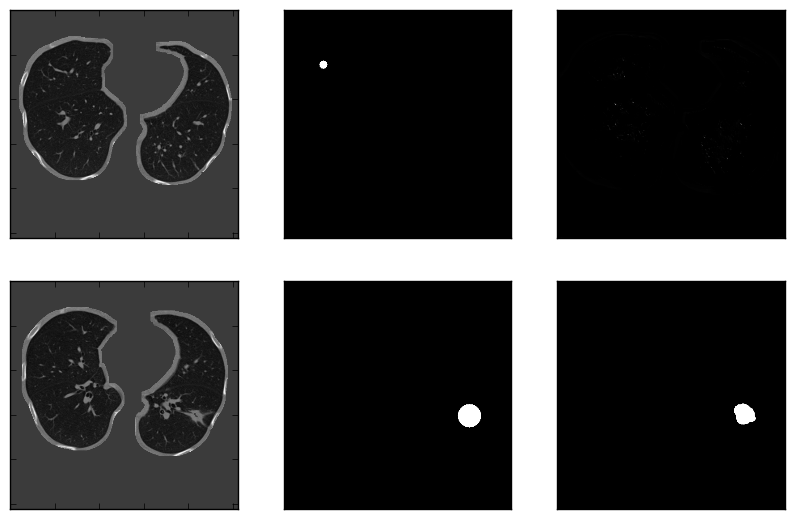

In [18]:
import matplotlib.gridspec as gridspec

# look at an output of the model
val_gen = lunaIterator(scan_path, df_val, batch_size=2, shuffle=True)
val_lungs, val_masks = next(val_gen)
out_masks = model.predict(val_lungs, batch_size=2)

fig, ax = plt.subplots(len(out_masks),3,figsize=[10,7])
for i in range(0, len(out_masks)):
    ax[i,0].imshow(val_lungs[i, 0], cmap=plt.cm.gray)
    ax[i,0].set_yticklabels([])
    ax[i,0].set_xticklabels([])
    
    ax[i,1].imshow(val_masks[i, 0], cmap=plt.cm.gray)
    ax[i,1].set_yticklabels([])
    ax[i,1].set_xticklabels([])
    
    ax[i,2].imshow(out_masks[i, 0], cmap=plt.cm.gray)
    ax[i,2].set_yticklabels([])
    ax[i,2].set_xticklabels([])
#plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)
plt.show()

In [19]:
# fig.savefig('out_small.png', bbox_inches='tight')